In [1]:
import theano
from theano import tensor as T

# 初期化
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# コンパイル
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 実行
print('Net input: %.2f' % net_input(2.0, 1.0, 0.5))

Net input: 2.50


In [2]:
# on default
print(theano.config.floatX)

float64


In [3]:
# change to float32
theano.config.floatX = 'float32'

In [4]:
print(theano.config.floatX)

float32


In [5]:
# check whether CPU or GPU is used
print(theano.config.device)

cpu


In [6]:
import numpy as np

# 初期化
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# コンパイル
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# 実行（Pythonリスト）
ary = [[1,2,3],[1,2,3]]
print('Column sum:', calc_sum(ary))

# 実行（NumPy配列）
ary = np.array([[1,2,3],[1,2,3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [7]:
print(x.type())

<TensorType(float32, matrix)>


In [8]:
# 初期化
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w+1.0]]

# コンパイル
net_input = theano.function(inputs=[x],
                            updates=update,
                            outputs=z)

# 実行
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [9]:
# 最小二乗法 線形回帰分析

# データセットを作成
X_train = np.asarray([[0.0], [1.0],
                     [2.0], [3.0],
                     [4.0], [5.0],
                     [6.0], [7.0],
                     [8.0], [9.0]],
                     dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3,
                      3.1, 2.0,
                      5.0, 6.3,
                      6.6, 7.4,
                      8.0, 9.0],
                      dtype=theano.config.floatX)

In [10]:
# 線形回帰モデルの重みを学習
def train_linreg(X_train, y_train, eta, epochs):

    costs = []

    # 配列の初期化
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y')
    X = T.fmatrix(name='X')
    # 重みを作成
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1),
                               dtype=theano.config.floatX),
                               name='w')
    # コストの計算
    # 総入力を計算
    net_input = T.dot(X, w[1:]) + w[0]
    # w[0]はバイアスユニット。つまり、x=0でのy軸の切片
    errors = y - net_input
    # 教師ラベル(y)と予測(net_input)の誤差
    cost = T.sum(T.pow(errors, 2))
    # 誤差の二乗和
    # このcostが最小になるようにトレーニングする

    # 重みの更新
    # wrtパラメータに渡された引数を自動的に微分する
    gradient = T.grad(cost, wrt=w)
    # コストの勾配(微分)
    update = [(w, w - eta0 * gradient)]
    # コストの勾配に学習率を掛ける
    # 重みを更新

    # モデルのコンパル
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train, y: y_train})

    # '_'は、イテレーションが回数分だけ行われることを示すために利用される
    for _ in range(epochs):
        costs.append(train(eta))

    return costs, w

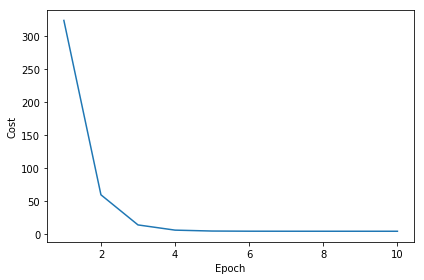

In [11]:
import matplotlib.pyplot as plt
costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

In [12]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt],
                              givens={w: w},
                              outputs=net_input)
    return predict(X)

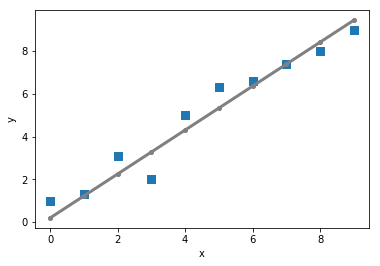

In [13]:
plt.scatter(X_train,
            y_train,
            marker='s',
            s=50)
plt.plot(range(X_train.shape[0]),
         predict_linreg(X_train, w),
         color='gray',
         marker='o',
         markersize=4,
         linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([[0.0, 0.2, 0.4]])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w[0]))

P(y=1|x) = 0.707


In [15]:
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

A = np.array([[1.0],
              [0.1],
              [0.3],
              [0.7]])

Z = W.dot(A)
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [16]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])
# classes are 0, 1, and 2

predicted class label: 2


In [17]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)
print(y_probas.sum())

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]
1.0


In [18]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


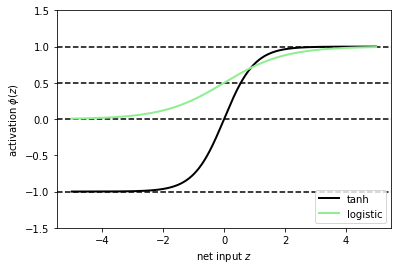

In [19]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)

log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.plot(z, tanh_act, linewidth=2, color='black', label='tanh')
plt.plot(z, log_act, linewidth=2, color='lightgreen', label='logistic')
plt.legend(loc='lower right')
plt.show()

In [1]:
# ------------------------------
# ------------------------------
# ------------------------------
# ---------           ----------
# ---------   Keras   ---------- from below
# ---------           ----------
# ------------------------------
# ------------------------------
# ------------------------------

import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    # パスを設定
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)

    # rb：読み込みのバイナリモード
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換（magic-numberはファイルのプロトコル）
        magic, n = struct.unpack('>II', lbpath.read(8))
        # 配列を構築
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 配列のサイズも変更
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [2]:
X_train, y_train = load_mnist('mnist', kind="train")
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('mnist', kind="t10k")
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [3]:
import theano

# MNISTの画像配列を32ビット形式に変関する
theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

In [4]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Backend ok


Using Theano backend.


In [5]:
# export KERAS_BACKEND=theano in terminal would change keras backend to theano for that session

# クラスラベルをone-hotフォーマットに変換
from keras.utils import np_utils
print('First 3 labels: ', y_train[:3])
y_train_ohe = np_utils.to_categorical(y_train)
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [7]:
# ニューラルネットワークを実装する
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

# モデルを初期化
model = Sequential()

# 隠れ層１
model.add(Dense(input_dim=X_train.shape[1],
                output_dim=50,
                init='uniform',
                activation='tanh'))

# 隠れ層２
model.add(Dense(input_dim=50,
                output_dim=50,
                init='uniform',
                activation='tanh'))

# 出力層
model.add(Dense(input_dim=50,
                output_dim=y_train_ohe.shape[1],
                init='uniform',
                activation='softmax'))

# モデルコンパイル時のオプティマイザを設定
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
# モデルをコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

/Users/takafumih/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=784, activation="tanh", units=50, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
/Users/takafumih/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="tanh", units=50, kernel_initializer="uniform")`
/Users/takafumih/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="softmax", units=10, kernel_initializer="uniform")`


In [10]:
# モデルをトレーニングする

model.fit(X_train,
          y_train_ohe,
          nb_epoch=50,
          batch_size=300,
          verbose=1,
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
25500/54000 [=============>................] - ETA: 0s - loss: 0.1562 - acc: 0.9519

/Users/takafumih/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


54000/54000 [==============================] - 0s 6us/step - loss: 0.1506 - acc: 0.9541 - val_loss: 0.1466 - val_acc: 0.9583
Epoch 2/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1527 - acc: 0.9548 - val_loss: 0.1534 - val_acc: 0.9555
Epoch 3/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1548 - acc: 0.9538 - val_loss: 0.1532 - val_acc: 0.9562
Epoch 4/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1447 - acc: 0.9562 - val_loss: 0.1537 - val_acc: 0.9570
Epoch 5/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1516 - acc: 0.9543 - val_loss: 0.1406 - val_acc: 0.9587
Epoch 6/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1484 - acc: 0.9555 - val_loss: 0.1460 - val_acc: 0.9583
Epoch 7/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.1487 - acc: 0.9551 - val_loss: 0.1500 - val_acc: 0.9568
Epoch 8/50
54000/54000 [==============================] - 0

In [13]:
# クラスラベルを予測する
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [14]:
# トレーニングの正解率を出力する
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc*100))

Training accuracy: 96.28%


In [17]:
# テストの正解率を出力する
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc*100))

Test accuracy: 95.26%
